# **Customer Clustering**
- The objective of this task is to cluster customers of a shopping mall to understand customers better in order to retain said customers.

Questions to be answered:

- How to perform customer segmentation using unsupervised machine learning algorithm in Python?
- Describe the characteristics of each customer cluster.
- Which group of customer is the most valuable to the shopping mall so that the shopping mall should do something to retain them?

In [62]:
!pip install kneed

In [147]:
from typing import Sequence, Tuple
from itertools import combinations, chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score

df = pd.read_csv("Customer_Dataset.csv")

## **Data Exploration**

In [148]:
df.head()

,CustomerID,Gender,Age,Income (k$),How Much They Spend
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [149]:
rows, cols = df.shape
print("There are {} rows and {} features in the data.".format(rows, cols))

There are 200 rows and 5 features in the data.


In [150]:
df.describe(include='all')

,CustomerID,Gender,Age,Income (k$),How Much They Spend
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


From the `.head` function, we find that:

|Columns|	Descriptions|
| :---: | :---: |
|CustomerId| Unique identifier for each customer |
|Gender| Gender of each customer |
|Age| Age of customers |
|Annual Income (k$)| Annual Income of the customer in thousands|
|Spending Score (1-100)| Score assigned by the mall based on customer behavior and spending nature |

In total, there are 4 numerical columns, `CustomerID` , `Age` , `Income (k$)` and `How Much They Spend` and only 1 categorical column, `Gender`

## **Exploratory Data Analysis**

Firstly, I would like to edit some of the feature names so that they are easier to use and less confusing for me.

In this section, I would like to:
- Perform univariate/bivariate analysis
- Check the distribution of numerical data
- Check the count of categorical data
- Identify columns that require scaling
- Find any correlations between features/ Any clusters formed

In [151]:
new_names = { 
    'CustomerID': 'cust_id',
    'Gender': 'gender',
    'Age': 'age', 
    'Income (k$)': 'salary(k$)',
    'How Much They Spend': 'amt_spent',
}
df.rename(columns = new_names, inplace=True)
df.head()

,cust_id,gender,age,salary(k$),amt_spent
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


#### **Univariate Analysis**

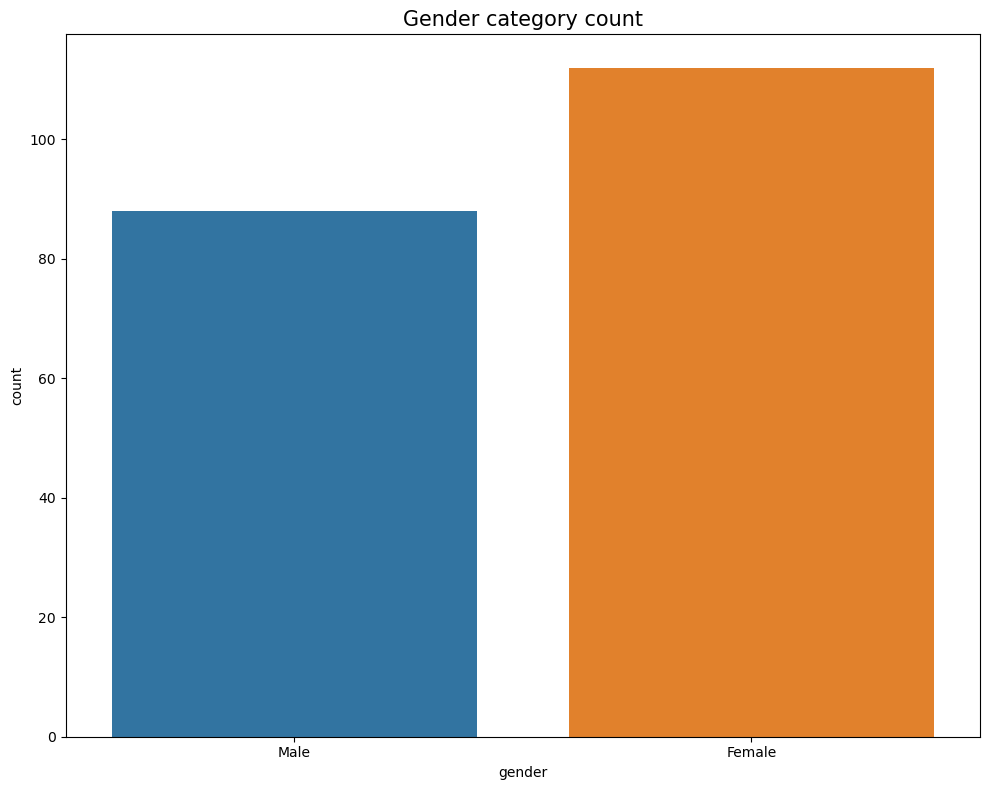

In [152]:
# Categorical count

fig = plt.figure(tight_layout = True, figsize = (10, 8))
ax = sns.countplot(x = df['gender'], data = df)
ax.set_title(f'Gender category count', fontsize=15)

plt.show()

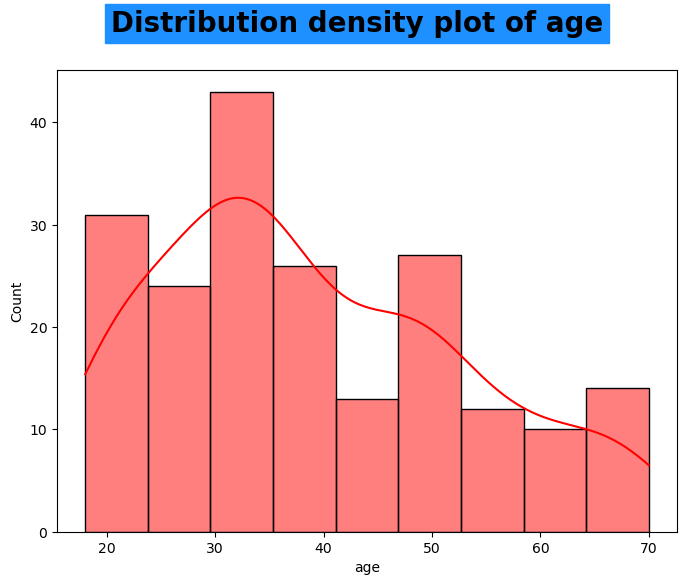

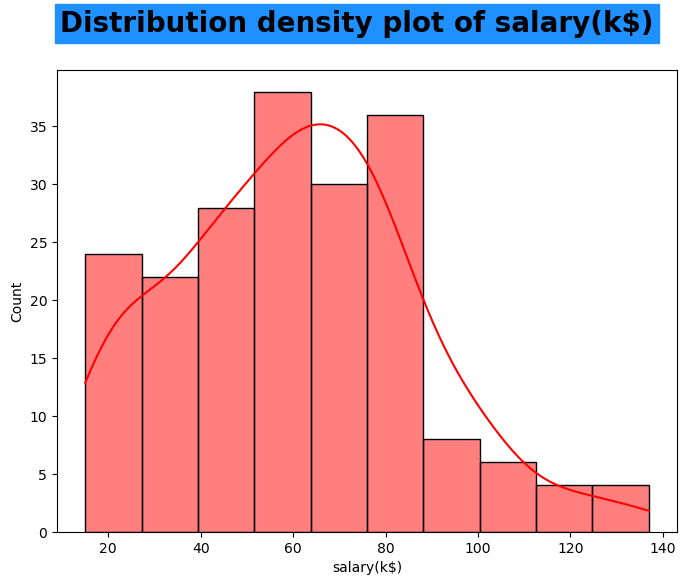

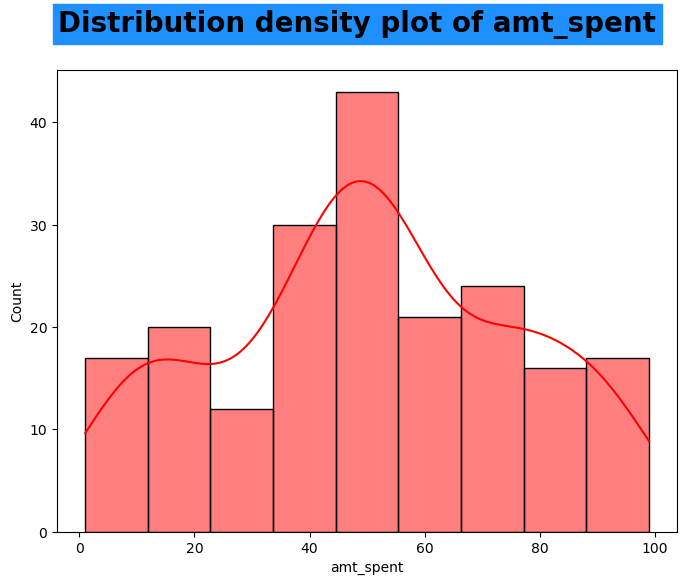

In [153]:
#Data Distribution
quant_features = ['age', 'salary(k$)', 'amt_spent']

for feature in quant_features:
  fig = plt.figure(figsize=(8,6))
  sns.histplot(data=df, x = feature, kde=True, color='red', alpha=0.5)

  fig.suptitle(f'Distribution density plot of {feature}',color='black',weight='bold',size=20, backgroundcolor= 'Dodgerblue')

  plt.show()

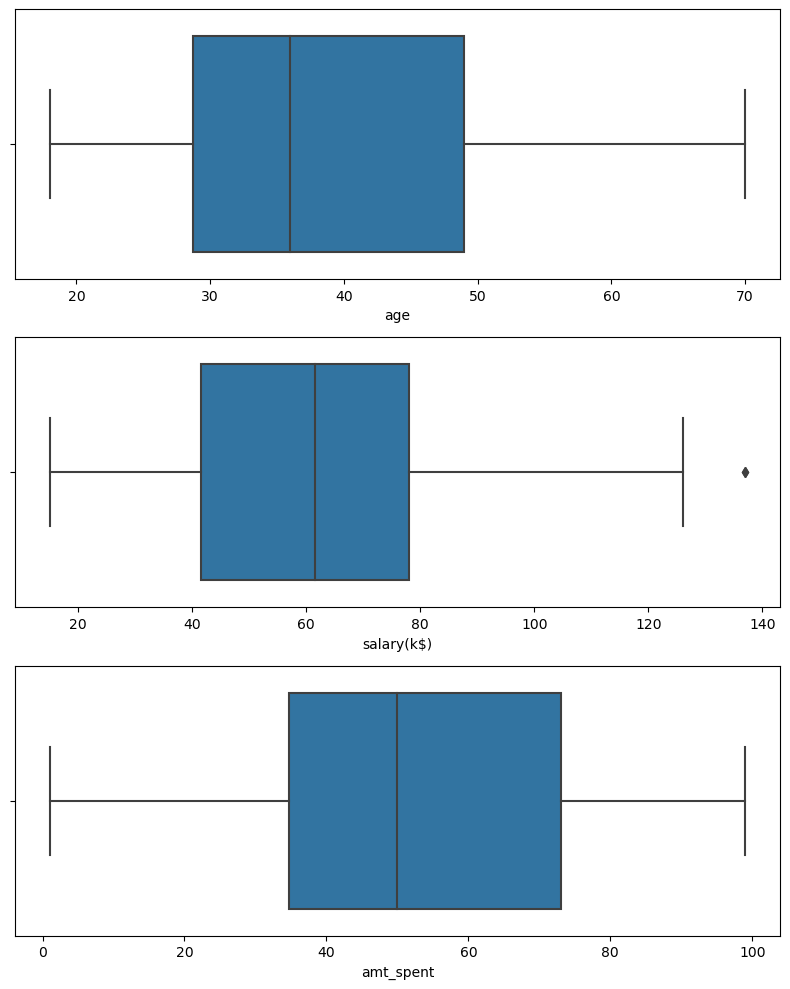

In [154]:
fig, ax = plt.subplots(len(quant_features), 1, figsize=(8, 10), tight_layout=True)
for idx, feature in enumerate(quant_features):
    sns.boxplot(data = df, x=feature, ax = ax[idx])
fig.show()

As we can see from the univariate analysis, all of the variables require normalising. `salary` and `age` is positively skewed while amt_spent actually has a quite similar distribution to gaussian distribution. I feel that there is no need to scale due to the fact that the range of each data is quite similar. 

From the boxplot, we can see that:

- The average:
    - Age is about 36
    - Salary is about $62000 a year
    - amt_spent (from a range of 0-100) is 45
- There is only one outlier in all 3 features, which is salary.

#### **Pairplot**

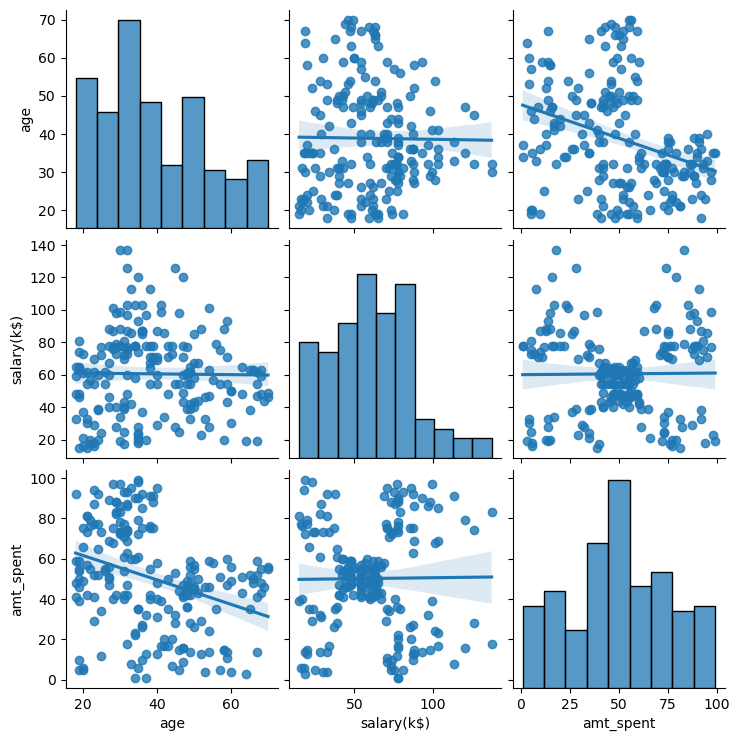

In [155]:
#Drop gender and cust id from df
df_num = df.drop(columns=['gender', 'cust_id'], axis=1)
sns.pairplot(df_num, kind='reg')

As we can see from the pairplot: 
- There are 5 natural clusters that appear between the amount spent and salary earnt
- We can also see that as the customers age increasing, the amount of money spent decreases.
- Apart from Age and Amount spent, there are no other significant relationships.
However to validify the last point, I will also plot a correlation plot.

In the next correlation plot, I will be using phi k as the correlation coefficient. It is better at identifying non linear relationships that may be available between different features. This identifies dependencies between each pair of variables better. This photo represents it:


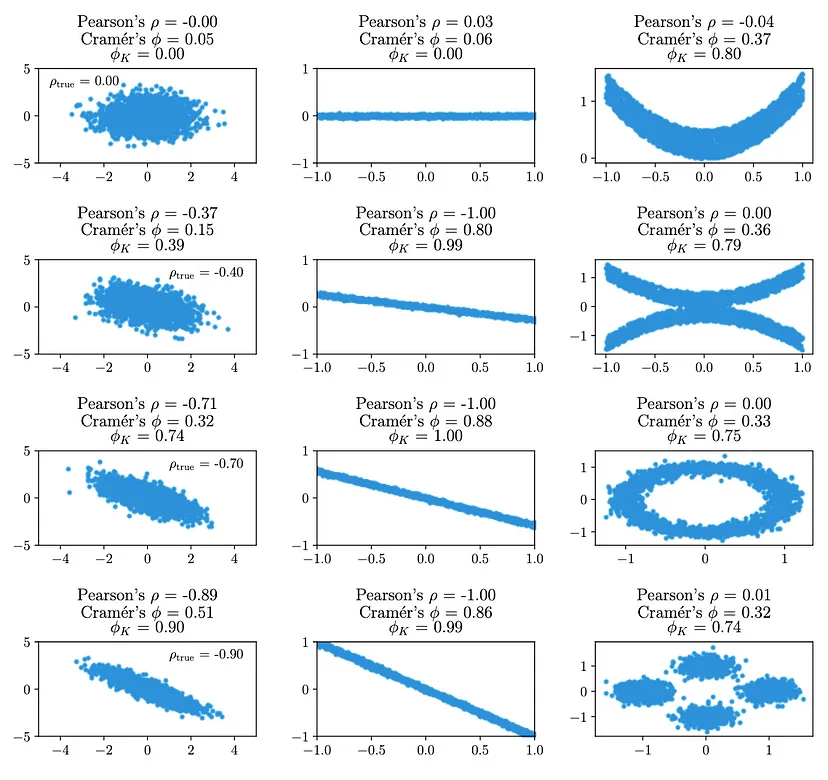

interval columns not set, guessing: ['age', 'salary(k$)', 'amt_spent']


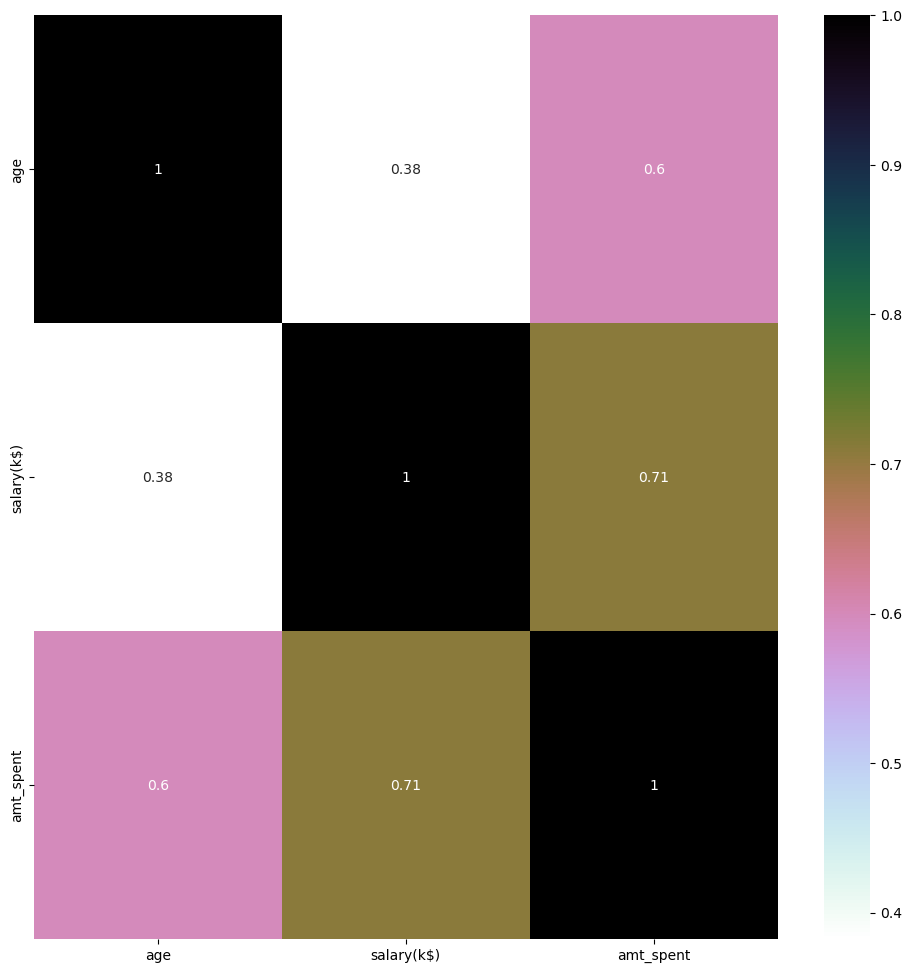

In [156]:
import phik
from phik.report import plot_correlation_matrix
from phik import report
from phik import resources, report

plt.figure(figsize=(12,12))
sns.heatmap(
    df_num.phik_matrix(),
    cmap="cubehelix_r",
    annot = True)
plt.show()

As we can see from the $\varphi_k$ correlation coefficient, `salary`/`amt_spent` and `age`/`amt_spent` have a moderate positive correlation. This could be because:
- People who earn more money would be able to spend more as they have more leeway for cash as a result of their salary. Hence they would naturally spend more as compared to someone who earns lesser money.
- Older people may need more, especially groups such as parents, as compared to students. This may be the reason why older customers tend to spend more money.


 On the other hand, `salary` and `age` have a weak correlation coefficient. 

## **Data Preprocessing**

There are a few steps that need to be performed before I can start clustering to ensure that the data is in a suitable format for analysis and modeling and handle any inherent issues or limitations in the data.
 1. As customer id is a unique identifier given to all customers and does not review any useful information, I will drop the column. 
 2. Next, as seen earlier, we will need to normalise the data as some are positively skewed.
 3. I need to create a dichotomous variable for `Gender`.
 4. I would also like to do feature selection and see if ALL of the features are needed, or whether, there is an optimal number/some features that I can drop.


In [157]:
#Drop cust_id
clean_df = df.drop(columns=['cust_id'], axis=1)

In [158]:
#Encoding gender column where gender_Male = 1 means that the customer is male
clean_df = pd.get_dummies(clean_df, drop_first=True)

In [159]:
clean_df

,age,salary(k$),amt_spent,gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0
...,...,...,...,...
195,35,120,79,0
196,45,126,28,0
197,32,126,74,1
198,32,137,18,1


In [160]:
#Normalise data
'''
In this case, I'll be using Quantile Transformer. This is because it transforms the data to follow a uniform or Gaussian distribution and is useful for handling skewed data.
This is perfect for the features in this dataset as they are all positvely skewed with very little outliers. 
'''
from sklearn.preprocessing import QuantileTransformer
def apply_quantile_transform(df, numcols, n_quantiles=100, random_state=None):
    qt = QuantileTransformer(n_quantiles=n_quantiles, random_state=random_state)

    df[numcols] = qt.fit_transform(df[numcols])
    
    return df

df_transformed = apply_quantile_transform(clean_df, quant_features ,n_quantiles=100, random_state=42)

In [161]:
display(df_transformed)

,age,salary(k$),amt_spent,gender_Male
0,0.035354,0.000000,0.291719,1
1,0.095960,0.000000,0.858586,1
2,0.065657,0.010101,0.050000,0
3,0.136364,0.010101,0.828283,0
4,0.328283,0.020202,0.303030,0
...,...,...,...,...
195,0.469697,0.979798,0.848485,0
196,0.666667,0.989899,0.212121,0
197,0.373737,0.989899,0.780000,1
198,0.373737,1.000000,0.164600,1


# **Model + Feature Selection**

#### **Feature Selection**

For feature selection, I decided to use a Genetic Algorithm. I think these 2 photos are enough to describe the process of using a genetic algorithm to select features.<br>

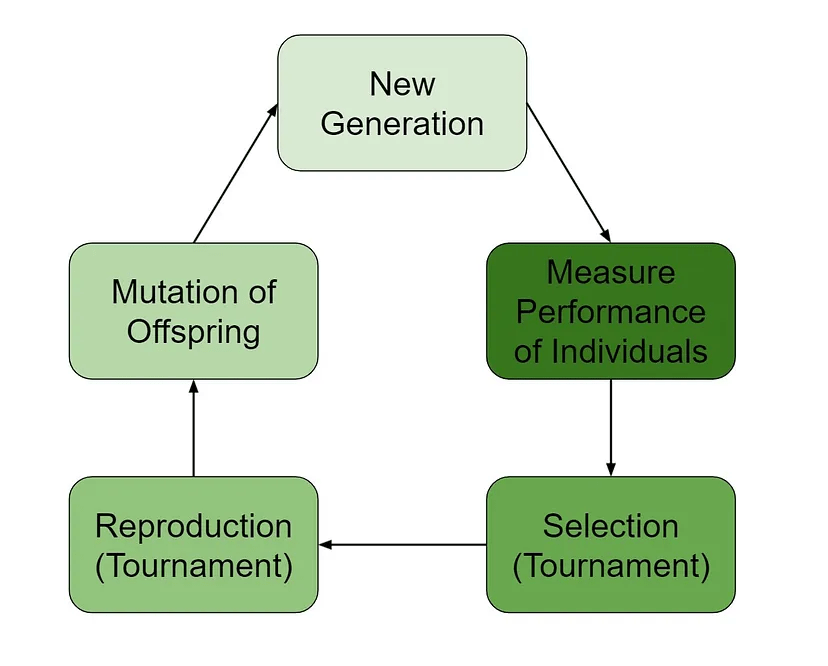<br>

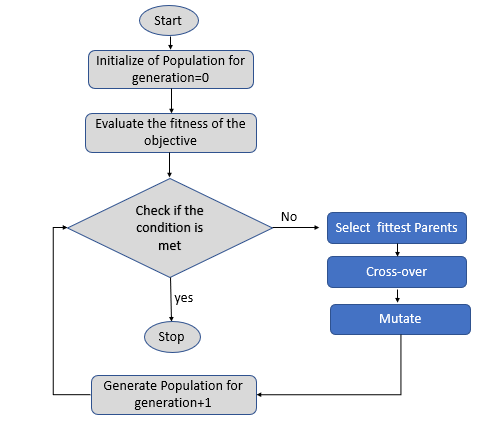

But before doing so, I need to decide on a model to use in order to score each feature, as well as the scoring metric. For scoring metrics, there are 2 kinds, extrinsic and intrinsic scoring metrics.However, extrinsic scoring metrics require ground-truth labels, which make them more fitting for a more semi-supervised learning where there are some labels on the data given. Some examples are: Fowlkes-Mallows Index and Adjusted Rand Index. Both of these scoring metrics are suitable when you have access to true class labels and want to measure how well the clustering aligns with the known classes. Here, it is an unsupervised learning project, where the data is completely unlabelled and clusters have to be formed by models. Hence, intrinsic models are more fitting based on context. In this project, these are my options:

<div style="text-align: center;">
    <h3>Baseline models<h3>
</div>

<div align="center">

|Model Name|Advantages/Uses|
|:----:|:----:|
|K-Mean Clustering|Very straightforward, easy to implement and understand. Works regardless of dataset size, quite efficient. Works better when the clusters are more defined.|
|Hierarchical Clustering|Works by finding hierarchy of clusters, at different granularities. Don't need to indicate number of clusters, makes it easier to deal with data of different structures.|
|DBSCAN|Can discover clusters with arbitrary shapes and varying densities. It is particularly effective for datasets where clusters are not well-separated or have irregular shapes.|

</div>
<br>
<div style="text-align: center;">
    <h3>Scoring metrics<h3>
</div>

<div align="center">

|Scoring Metric|Advantages/Uses|
|:----:|:----:|
|Inertia (Within-Cluster Sum of Squares)|Measures how compact clusters are, minimize sum of squared distance within each cluster. Lower score better clusters.|
|Silhouette Score|Captures both cohesion and separation of clusters. Measures how similar an object is to its own cluster compared to other clusters. Higher scores indicate well-defined clusters|
|Calinski-Harabasz Index|Measures the ratio of between-cluster variance to within-cluster variance. Higher values indicate well-separated clusters. Useful for comparing different clustering algorithms.|
|Davies-Bouldin Index|Measures the average similarity between each cluster and its most similar cluster, while considering the size of the clusters. Lower values indicate better-defined clusters. Helps identify compact, well-separated, and evenly sized clusters.|

</div>

From these, I have decided on the scoring metric and baseline model to use:

#### **Baseline Model:**
- K-Mean Clustering would be the most suitable one. This is because of how simple and efficient it is to use, hence would be able to be more efficient in deciding which features to use. By picking a model that is easy to understand and intuitive, the algorithm is able to decide which features to drop easily.

#### **Scoring Metric:**
- All of the scoring metrics are (technically) usable, but based on research:

    - Silhouette Score can be more computationally intensive, relative to the other considered metrics.
    - Inertia is not always easy to interpret directly in the context of cluster quality.
    - Calinski-Harabasz Index may not work well if the data has varying cluster densities.
    - Davies-Bouldin Index can be sensitive to noise and outliers.<br><br>

- Therefore, based on context and my data visualisation, I decided to use the Davies-Bouldin index. I could have chosen the Calinski-Harabasz Index too, but as I am unsure of how the cluster densities are, I have chosen to avoid it. On the other hand, as there was only 1 outlier detected among all the variables, the Davies-Bouldin index would do very well as there is minimal limitation.

However, to do genetic algorithm, I will first need to find the optimal number of clusters such that the algorithm can judge what is a good result and what isnt.



## **Elbow Plot**

One way we can try to find out is to use a data sample to create a series of clustering models with an incrementing number of clusters, and measure how tightly the data points are grouped within each cluster. A metric often used to measure this tightness is the within cluster sum of squares (WCSS), with lower values meaning that the data points are closer. We can then plot the WCSS for each model.

<div align="center">

WCSS = $\sum_{i=1}^{n} \sum_{x \in C_i} ||x - \mu_i||^2$


</div>

Where:
- $( n )$ is the total number of data points.
- $( C_i )$ represents the $( i )$ th cluster.
- $( x )$ denotes a data point within cluster $( C_i )$.
- $( mu_i )$ is the centroid mean of cluster $( C_i )$.
- $( ||x - \mu_i||^2 )$ represents the squared Euclidean distance between the data point $( x )$ and the centroid $( \mu_i )$.

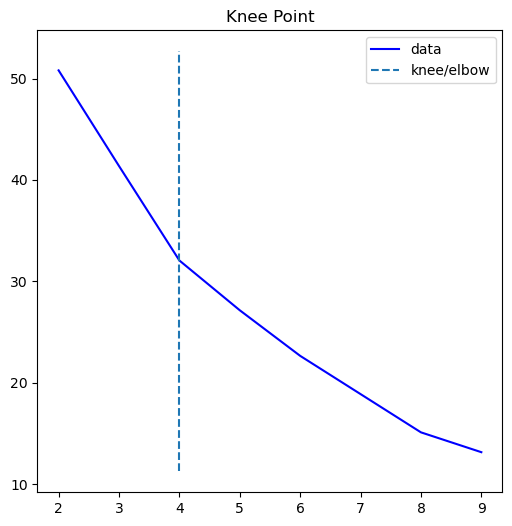

In [66]:
def kmeanMetrics_result(n_cluster: int, X: Sequence)-> Tuple[float, Sequence, Sequence, sklearn.cluster._kmeans.KMeans]:
    '''
    General Function to returns commonly used metrics for K-Means Clustering and the fitted instance
    '''
    kmean = KMeans(n_clusters = n_cluster, random_state=24,init='k-means++') # using the algorithm of k-means++
    cluster_labels = kmean.fit_predict(X)
    sqdist = kmean.transform(X)**2
    sqdist = sqdist.sum(axis=1).round(2)
    return kmean.inertia_, cluster_labels, kmean.cluster_centers_, kmean ,sqdist 

k_range = np.arange(2,10,1) # Max 10 clusters
  
k_results = pd.DataFrame(columns=['k','inertia','silhouette_score'])

for idx, k in enumerate(k_range):
    k_means_range_df =  clean_df.copy() # Reset k_means_range_df to original dataframe to assign cluster labels
    inertia , cluster_labels, cluster_centers, kmeans,sqdist = kmeanMetrics_result(n_cluster=k, X=k_means_range_df)
    k_means_range_df['Cluster'] = cluster_labels

    k_results.loc[idx] = [k,inertia,silhouette_score(k_means_range_df, cluster_labels)] 

from kneed import KneeLocator

kl = KneeLocator(k_results['k'], k_results['inertia'], curve="convex",direction="decreasing")
kl.plot_knee()

When I first plotted, I felt that the elbow point was too ambiguous, so I used a package called Kneed to locate the elbow/knee point. However, even after using the package, I feel that I should try a range of values, from 4-7. For my genetic algorithm, I will be sticking to 4 as the elbow point first.

Now, its time to start on the genetic algorithm for feature selection using K-Mean Clustering as my baseline model and Davies-Bouldin Index as my scoring metric:

In [109]:
from sklearn.metrics import davies_bouldin_score

def evaluate_fitness(n_clusters, data, population):
    fitness_scores = []
    for subset in population:
        selected_features = data[:, subset == 1]
        if selected_features.shape[1] > 0:
            kmeans = KMeans(n_clusters, random_state = 42)
            labels = kmeans.fit_predict(selected_features)
            score = davies_bouldin_score(selected_features, labels)
            fitness_scores.append(score)
        else:
            fitness_scores.append(float('inf'))  # If no features are selected, set fitness score to infinity
    
    return fitness_scores

def select_candidates(population, fitness_scores, num_selected):
    selected_indices = []
    sorted_indices = np.argsort(fitness_scores)
    
    for _ in range(num_selected):
        idx1, idx2 = np.random.choice(sorted_indices[:num_selected], 2, replace=False)
        if fitness_scores[idx1] < fitness_scores[idx2]:
            selected_indices.append(idx1)
        else:
            selected_indices.append(idx2)
    
    return population[selected_indices]

def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def mutate(child, mutation_rate):
    for i in range(len(child)):
        if np.random.rand() < mutation_rate:
            child[i] = 1 - child[i]
    return child

def initialize_population(population_size, num_features, min_selected_features = 1, max_selected_features=None):
    population = []
    for _ in range(population_size):
        num_selected = np.random.randint(min_selected_features, num_features + 1) if max_selected_features is None else np.random.randint(min_selected_features, max_selected_features + 1)
        subset = np.zeros(num_features)
        selected_indices = np.random.choice(num_features, num_selected, replace=False)
        subset[selected_indices] = 1
        population.append(subset)
    return np.array(population)


def genetic_algorithm(n_clusters, data, num_generations = 10, population_size = 70, num_selected = 40, mutation_rate = 10, max_selected_features=None):
    num_samples, num_features = data.shape
    population = initialize_population(population_size, num_features, max_selected_features=max_selected_features) 
    
    for generation in range(num_generations):
        fitness_scores = evaluate_fitness(n_clusters, data, population)
        selected_candidates = select_candidates(population, fitness_scores, num_selected)
        new_population = []
        
        for i in range(0, len(selected_candidates), 2):
            parent1 = selected_candidates[i]
            parent2 = selected_candidates[i + 1] if i + 1 < len(selected_candidates) else parent1
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            new_population.append(child1)
            new_population.append(child2)
        
        population = np.array(new_population)
    
    best_fitness_index = np.argmin(fitness_scores)
    best_subset = population[best_fitness_index]
    
    return best_subset


if __name__ == "__main__":
    input_data = clean_df.values
    num_selected_features = 4
    n_clusters = 4
    best_subset = genetic_algorithm(n_clusters,input_data, max_selected_features=num_selected_features)
    print(best_subset)
    
    selected_feature_indices = np.where(best_subset == 1)[0]
    selected_feature_names = clean_df.columns[selected_feature_indices]
    
    print("Selected features:", selected_feature_names)
    
    # # Creating a DataFrame to display the results
    # result_df = pd.DataFrame({
    #     "BestFitness": np.min(fitness_scores, axis=1)
    # })
    
    # # Display the results
    # print("\nEvolution of Best Fitness:")
    # print(result_df)

[0. 1. 1. 1.]
Selected features: Index(['salary(k$)', 'amt_spent', 'gender_Male'], dtype='object')


Even though it dropped age, I feel that contextually it is still needed to identify the type of people that are in each cluster. As the algorithm might not see this and only look at it from an effectiveness stand point, I will still take age as a feature due to its contextual importance.

## **K-Means Clustering**

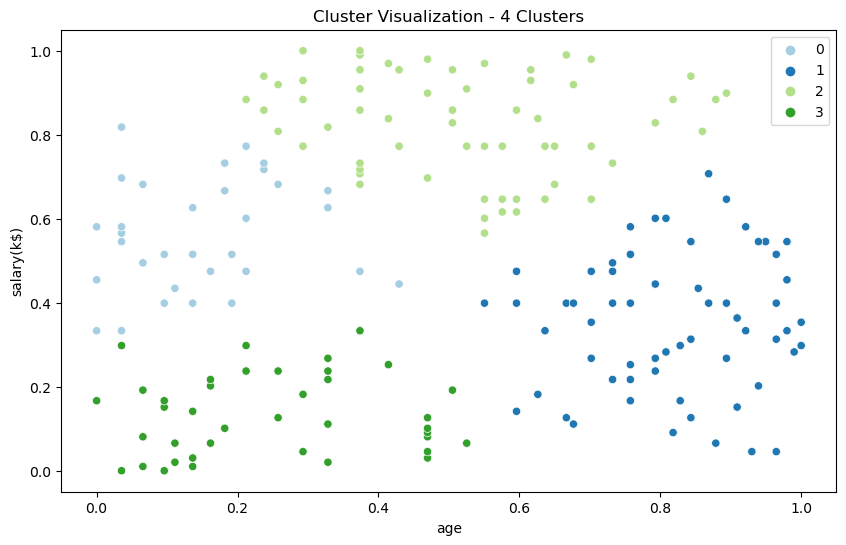

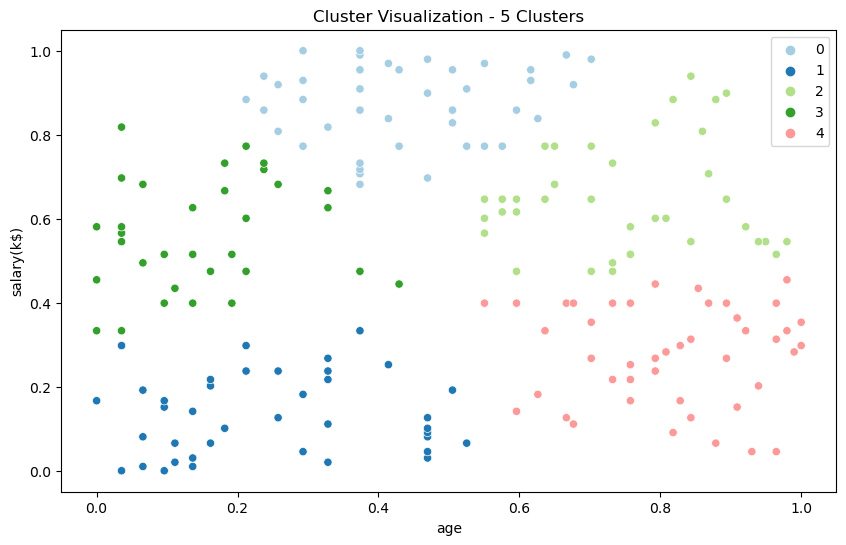

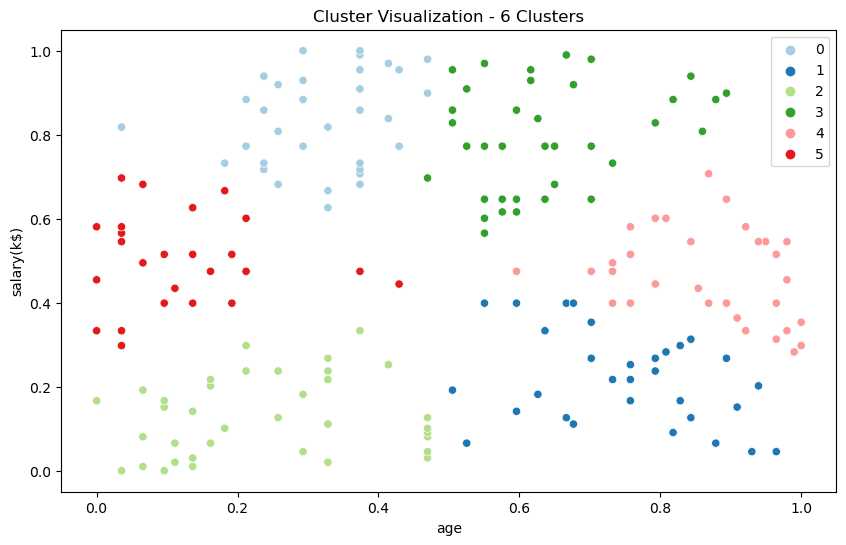

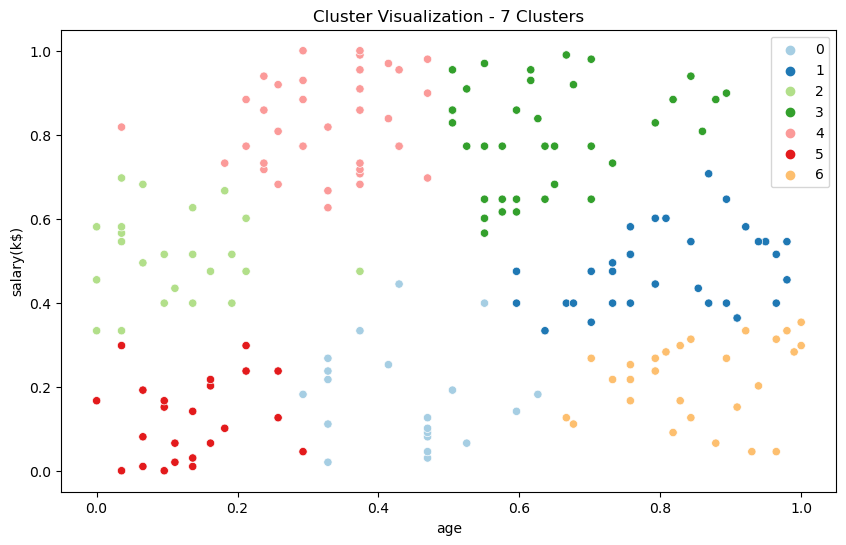

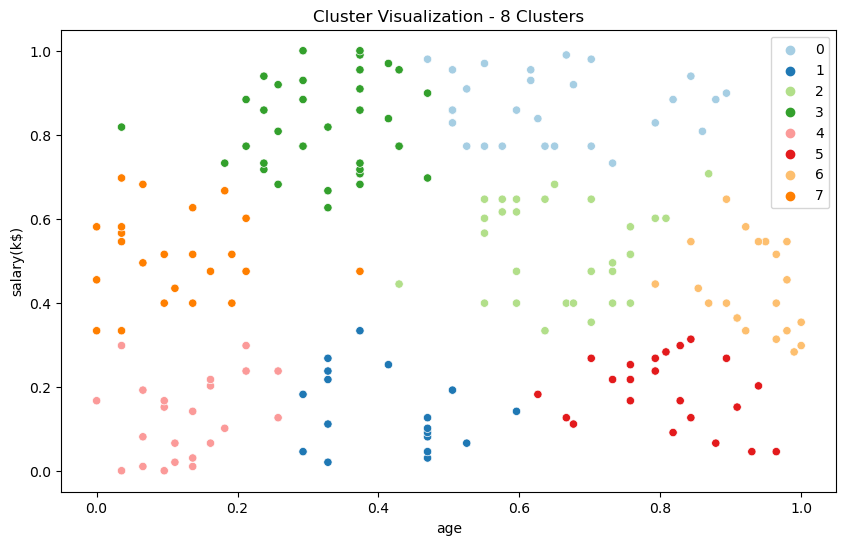

In [119]:
def cluster_visualization(data, n_clusters):
    kmeans = KMeans(random_state = 42, max_iter = 1000, n_clusters = n_clusters)
    labels = kmeans.fit_predict(data)
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data = data, x=data.iloc[:, 0], y = data.iloc[:, 1], hue=labels, palette="Paired")
    plt.title(f'Cluster Visualization - {n_clusters} Clusters')
    plt.show()

for n_clusters in range(4, 9):
    cluster_visualization(clean_df[['age', 'salary(k$)']], n_clusters)


In [169]:
def calculate_cluster_centroids(data):
    cluster_centers = data.groupby('ClusterLabel').mean()
    cluster_centers['ClusterSizePercentage'] = pd.Series(data['ClusterLabel']).value_counts() / len(data['ClusterLabel']) * 100
    return cluster_centers

kmeans_data = clean_df.copy()
kmeans_model = KMeans(n_clusters = 5, random_state=42)
cluster_labels = kmeans_model.fit_predict(clean_df) + 1
kmeans_data['ClusterLabel'] = cluster_labels
cluster_centroids = calculate_cluster_centroids(kmeans_data)

rename_df = df.copy()
rename_df = rename_df.rename(columns={'Age': 'age','Income (k$)': 'salary(k$)', 'How Much They Spend': 'amt_spent'})
print(rename_df)

quantile_transformer = QuantileTransformer(output_distribution='normal')
quantile_transformer.fit(rename_df[['age', 'salary(k$)', 'amt_spent']])

original_values = quantile_transformer.inverse_transform(cluster_centroids[['age', 'salary(k$)', 'amt_spent']])

cluster_centroids[['age', 'salary(k$)', 'amt_spent']] = original_values

print(cluster_centroids)

     cust_id  gender  age  salary(k$)  amt_spent
0          1    Male   19          15         39
1          2    Male   21          15         81
2          3  Female   20          16          6
3          4  Female   23          16         77
4          5  Female   31          17         40
..       ...     ...  ...         ...        ...
195      196  Female   35         120         79
196      197  Female   45         126         28
197      198    Male   32         126         74
198      199    Male   32         137         18
199      200    Male   30         137         83

[200 rows x 5 columns]
                    age  salary(k$)  amt_spent  gender_Male  \
ClusterLabel                                                  
1             40.000000   74.921358  73.000000          1.0   
2             44.000000   78.000000  75.000000          0.0   
3             49.957256   73.930359  55.989287          1.0   
4             49.000000   73.000000  56.000000          0.0   
5         

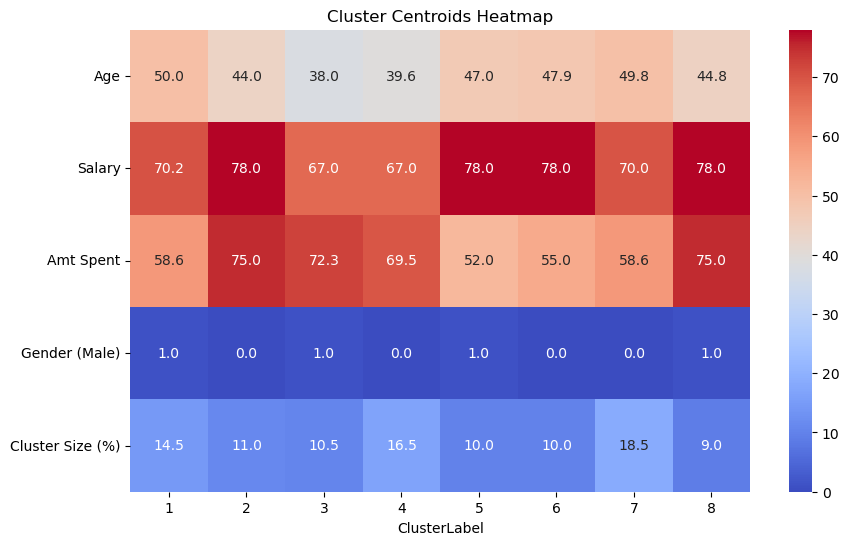

In [168]:
features_plotted = ['age', 'salary(k$)', 'amt_spent', 'gender_Male', 'ClusterSizePercentage']

features_df = cluster_centroids[features_plotted]

feature_labels = ['Age', 'Salary', 'Amt Spent', 'Gender (Male)', 'Cluster Size (%)']
features_df.columns = feature_labels

features_df = features_df.T

plt.figure(figsize=(10, 6))
sns.heatmap(features_df, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Cluster Centroids Heatmap")
plt.show()

I feel that 5 clusters is perfect as it has quite little outliers, at the same time 4 clusters feel like an oversimplification. We can see that are there are no major overlaps in the clusters, which is very good as it shows that different clusters have distinct characteristics. 

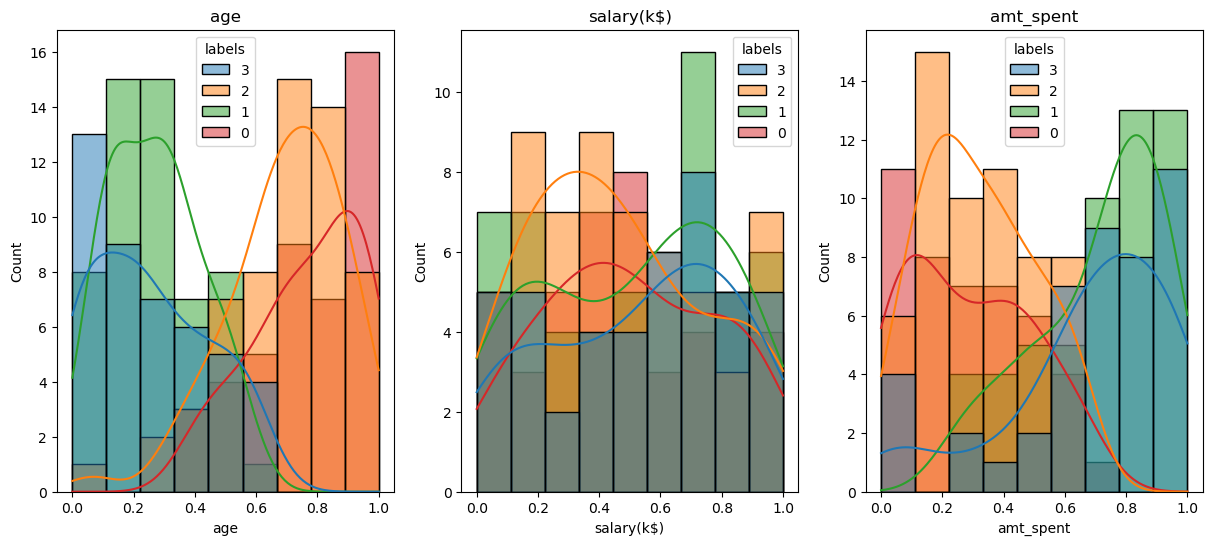

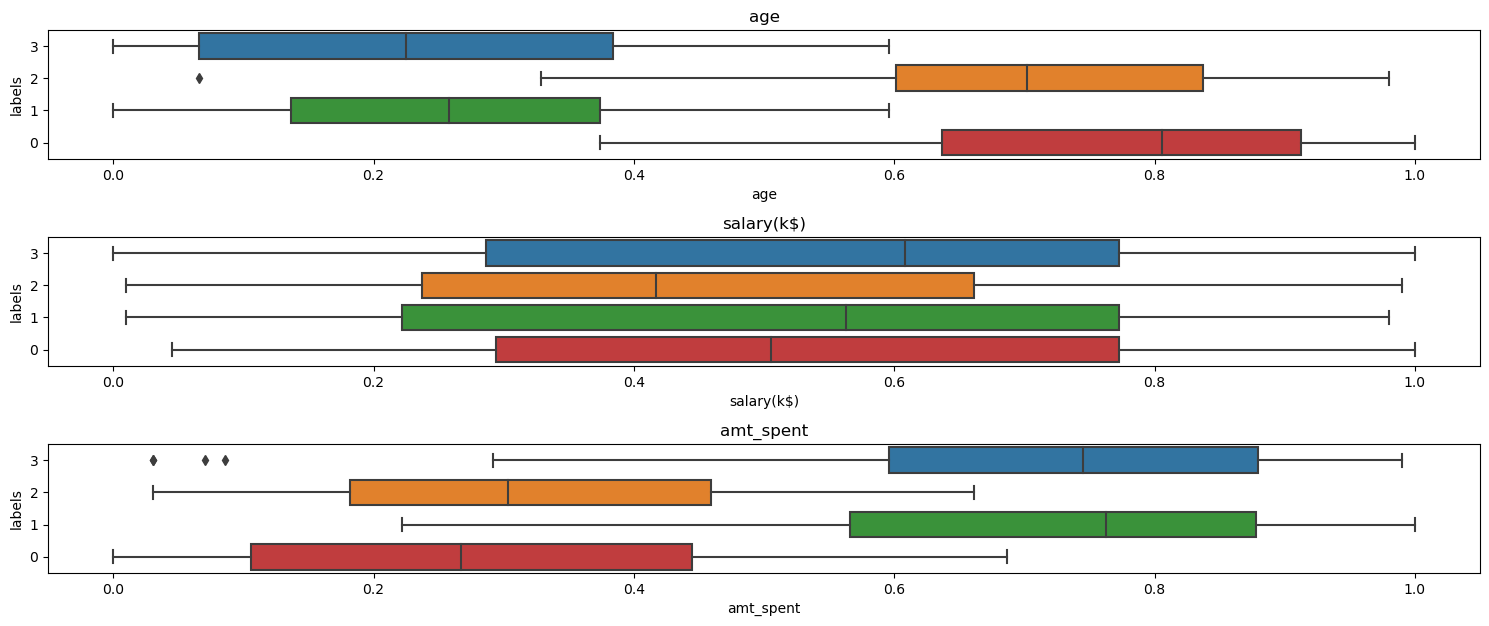

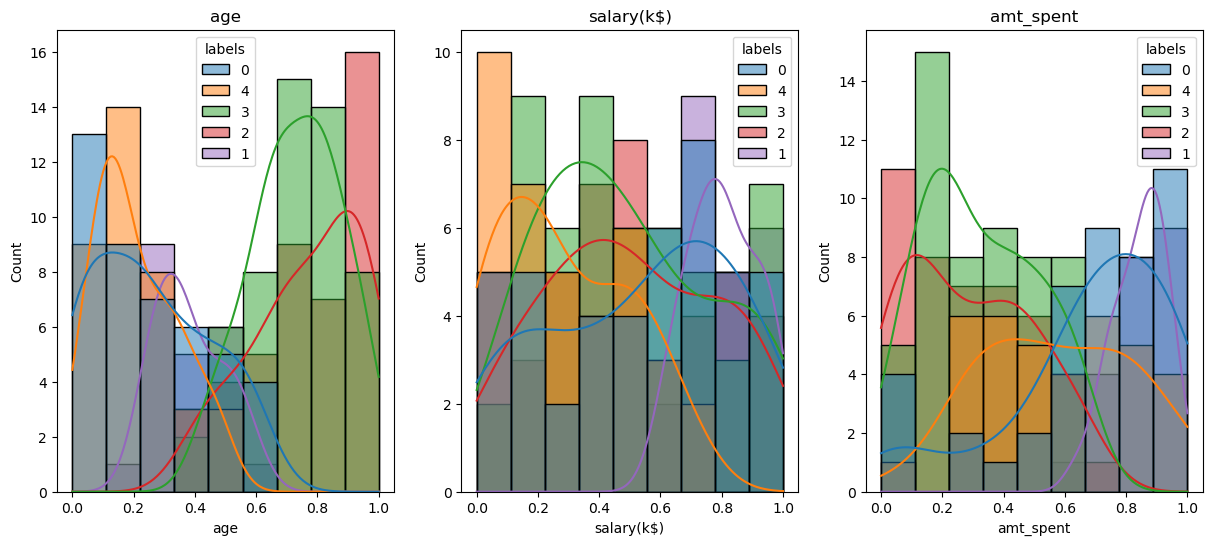

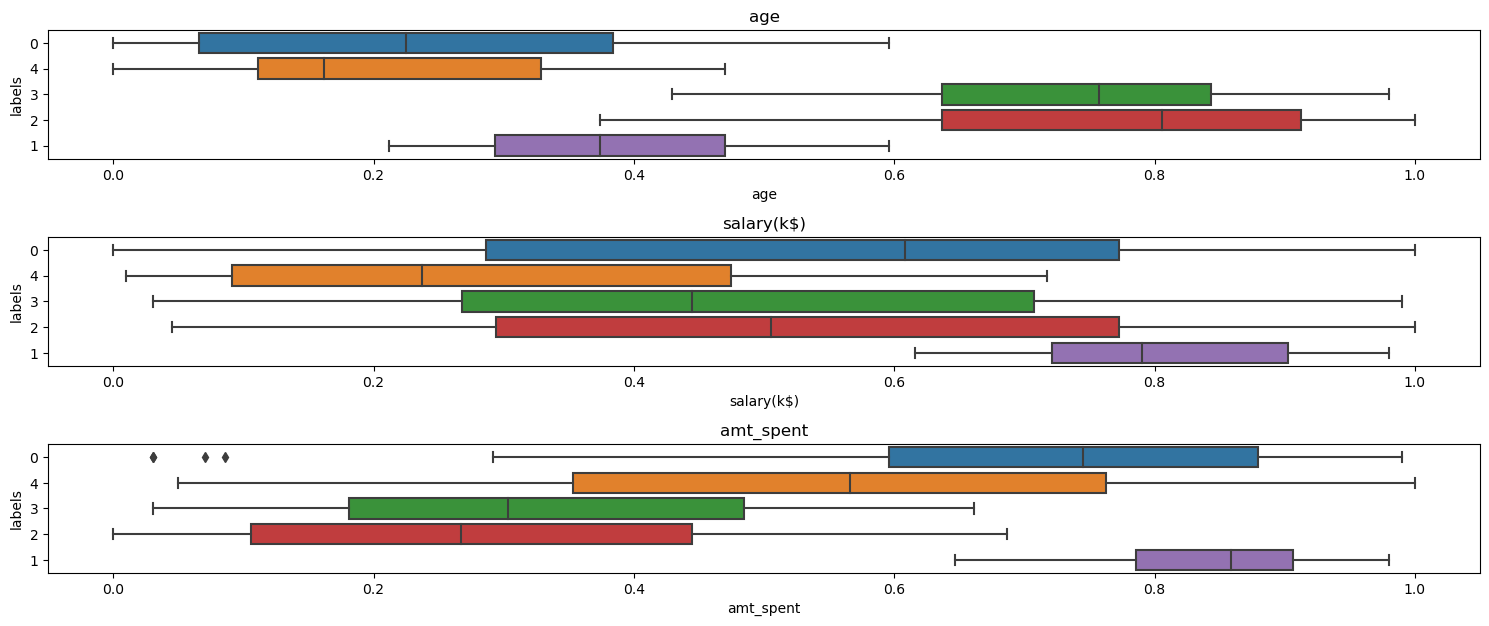

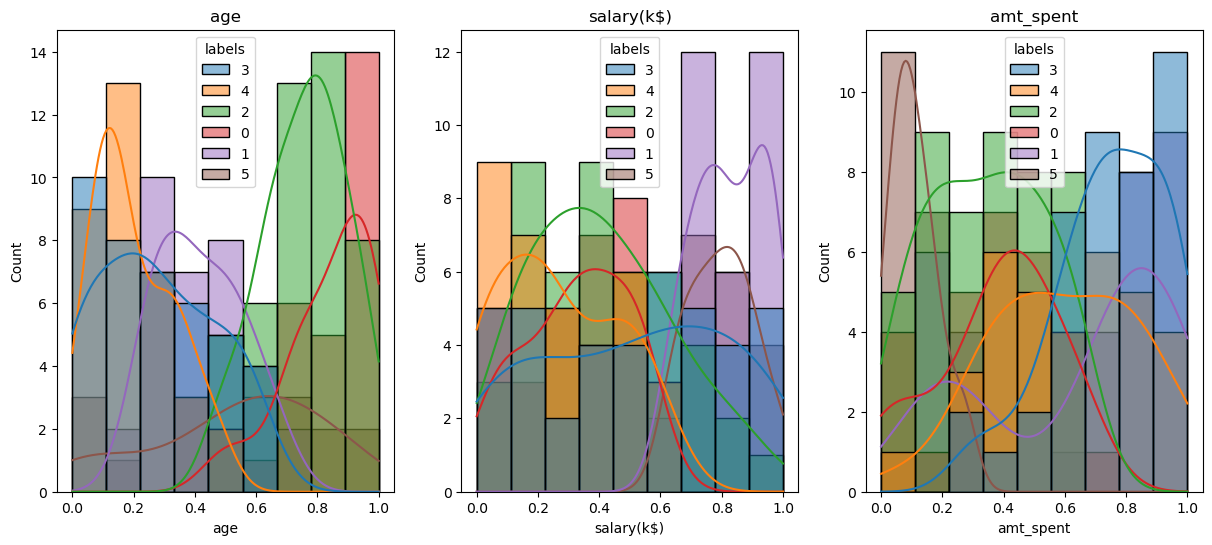

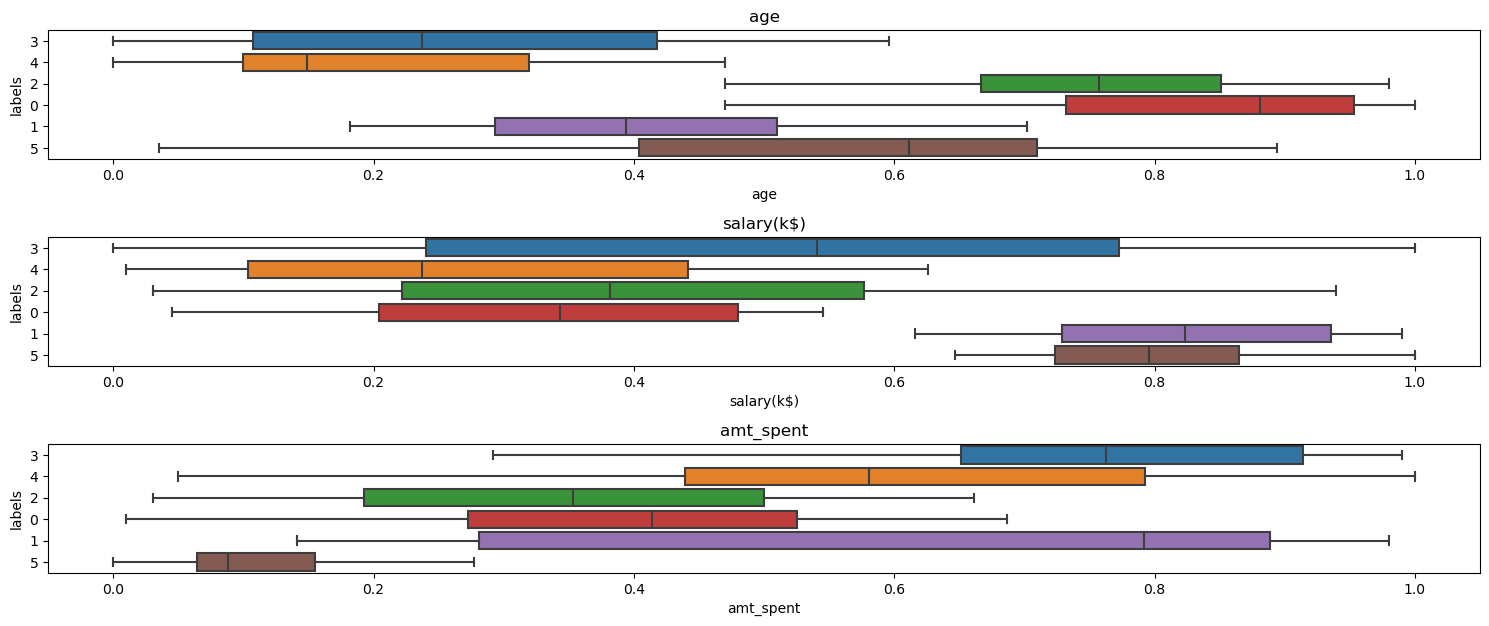

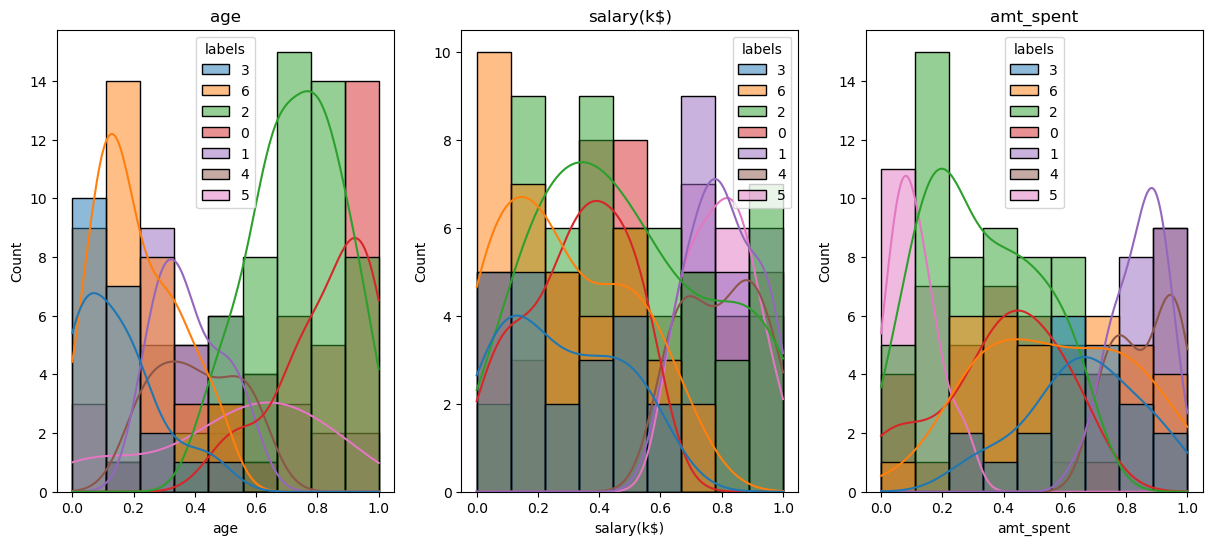

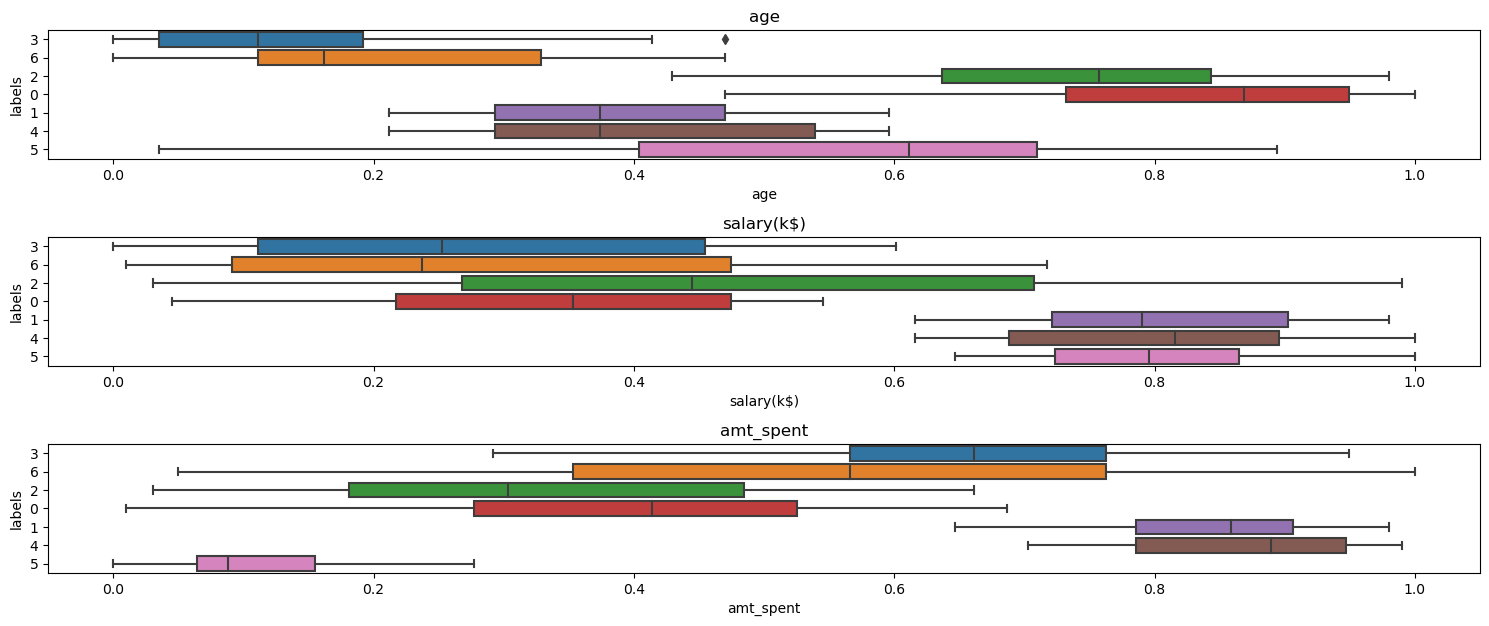

In [112]:

def cluster_eval(og_df, labels):
    labels_df = pd.DataFrame(labels, columns=['labels'])
    evals_df = pd.concat([og_df, labels_df], axis=1)
    # change datatype of labels to string
    evals_df['labels'] = evals_df['labels'].astype(str)

    numericals = ['age', 'salary(k$)', 'amt_spent']

    plt.figure(figsize=(20, 6))
    for i, feature in enumerate(numericals): # plot histograms for numerical features
        plt.subplot(1, 4, i+1)
        sns.histplot(data=evals_df, x=feature, kde=True, color='#2c7bb6', hue='labels')
        plt.title(feature)
    plt.show()

    plt.figure(tight_layout=True, figsize=(15, 8))
    for i, feature in enumerate(numericals): # plot boxplots for numerical features
        plt.subplot(4, 1, i+1)
        sns.boxplot(data=evals_df, x=feature, y='labels')
        plt.title(feature)
    plt.show()

for i in range(4, 8):
    kmeans = KMeans(random_state = 42, max_iter=1000, n_clusters = i) # instantiate kmeans object
    kmeans.fit(clean_df) # fit kmeans object to data
    labels = kmeans.labels_
    cluster_eval(clean_df, labels)

at the end, see if gender really makes a diff? like try to plot and see if theres a point keeping that column

<hr>

## **Sources**

https://www.kaggle.com/code/tanmayunhale/genetic-algorithm-for-feature-selection <br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html<br>
https://pyshark.com/davies-bouldin-index-for-k-means-clustering-evaluation-in-python/<br>
https://www.linkedin.com/advice/0/what-some-challenges-limitations-cluster-analysis <br>
https://medium.com/@haataa/how-to-measure-clustering-performances-when-there-are-no-ground-truth-db027e9a871c <br>
https://towardsdatascience.com/7-evaluation-metrics-for-clustering-algorithms-bdc537ff54d2 <br>
https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/<br>
https://chart-studio.plotly.com/~Diksha_Gabha/2853 <br>